# <center> <img src="../../labs/img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
### <center> **Big Data** </center>
---
### <center> **Spring 2025** </center>
---
**Mid-term exam**

**Date**: 3/12/2025

**Student Name**:

**Professor**: Pablo Camarillo Ramirez

In [5]:
import findspark
findspark.init()

In [43]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("SparkSQL-Exam-1-Aaron-Ortega") \
    .master("spark://93a435690e65:7077") \
    .config("spark.ui.port","4040") \
    .getOrCreate()
sc = spark.sparkContext

### Read the Data (10 points):
- Load the `sales.csv` and `products.csv` files into PySpark DataFrames. **You need to use your team's spark_utils implementation to produce the schema**.

In [42]:
import importlib
import team_ParDeDos.spark_utils

importlib.reload(team_ParDeDos.spark_utils)

columns_info = [
  ("product_id", "integer"),
  ("product_name", "string"),
  ("category", "string"),
  ("price", "double")
]

schema = team_ParDeDos.spark_utils.SparkUtils.generate_schema(columns_info)

# Create DataFrame
products_df = spark \
                .read \
                .schema(schema) \
                .option("header", "true") \
                .csv("/home/jovyan/notebooks/data/mid_exam/products.csv")

products_df.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- price: double (nullable = true)



In [44]:
products_df.show(5)

+----------+------------+-----------+------+
|product_id|product_name|   category| price|
+----------+------------+-----------+------+
|       100| Product 100|Electronics|143.16|
|       101| Product 101|      Books|782.24|
|       102| Product 102|       Toys|620.23|
|       103| Product 103|   Clothing|597.14|
|       104| Product 104|       Toys|130.96|
+----------+------------+-----------+------+
only showing top 5 rows



In [45]:
columns_info = [
  ("transaction_id", "integer"),
  ("product_id", "integer"),
  ("customer_id", "integer"),
  ("sale_amount", "double"),
  ("sale_date", "date")
]

schema = team_ParDeDos.spark_utils.SparkUtils.generate_schema(columns_info)

sales_df = spark.read \
                .schema(schema) \
                .option("header", "true") \
                .csv("/home/jovyan/notebooks/data/mid_exam/sales.csv")

sales_df.printSchema()

root
 |-- transaction_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- sale_amount: double (nullable = true)
 |-- sale_date: date (nullable = true)



In [46]:
sales_df.show(5)

+--------------+----------+-----------+-----------+----------+
|transaction_id|product_id|customer_id|sale_amount| sale_date|
+--------------+----------+-----------+-----------+----------+
|             1|       188|       1587|     155.46|2023-03-03|
|             2|       189|       1168|     292.97|2023-12-27|
|             3|       180|       1980|      843.5|2023-05-18|
|             4|       179|       1984|     486.38|2023-03-20|
|             5|       165|       1865|     220.58|2023-06-30|
+--------------+----------+-----------+-----------+----------+
only showing top 5 rows



### Join Operations (20 points):
- Join the `sales` DataFrame with the `products` DataFrame on `product_id` to enrich the sales data with product details.

In [47]:
join_result = sales_df.join(products_df,
														sales_df["product_id"] == products_df["product_id"],
														"left")

join_result.show(5)

+--------------+----------+-----------+-----------+----------+----------+------------+--------+------+
|transaction_id|product_id|customer_id|sale_amount| sale_date|product_id|product_name|category| price|
+--------------+----------+-----------+-----------+----------+----------+------------+--------+------+
|             1|       188|       1587|     155.46|2023-03-03|       188| Product 188|    Toys|491.24|
|             2|       189|       1168|     292.97|2023-12-27|       189| Product 189|Clothing|483.81|
|             3|       180|       1980|      843.5|2023-05-18|       180| Product 180|Clothing| 233.6|
|             4|       179|       1984|     486.38|2023-03-20|       179| Product 179|    Toys|377.16|
|             5|       165|       1865|     220.58|2023-06-30|       165| Product 165|    Toys| 472.1|
+--------------+----------+-----------+-----------+----------+----------+------------+--------+------+
only showing top 5 rows



### Group and Aggregate (10 points):
- Calculate the total sales amount (`sale_amount`) for each product category (`category`).

In [48]:
from pyspark.sql.functions import sum

total_sales_df = join_result.groupBy("category").agg(
	sum("sale_amount").alias("sum_sales")
)

total_sales_df.show()

+---------------+------------------+
|       category|         sum_sales|
+---------------+------------------+
|    Electronics| 317551.3199999997|
|       Clothing|456678.17999999964|
|          Books|351332.63000000035|
|Home Appliances|186122.48999999993|
|           Toys| 593078.7299999996|
+---------------+------------------+



### Transformations (Using `when()`) (20 points):
- Add a new column `sale_type` to the enriched sales DataFrame:
	- If `sale_amount` is greater than or equal to 50, set `sale_type` to "High".
	- Otherwise, set `sale_type` to "Low".

In [49]:
from pyspark.sql.functions import when

transformed_df = join_result.withColumn('sale_type', when(join_result['sale_amount'] >= 50, "High").otherwise("Low"))

transformed_df.show(5)

+--------------+----------+-----------+-----------+----------+----------+------------+--------+------+---------+
|transaction_id|product_id|customer_id|sale_amount| sale_date|product_id|product_name|category| price|sale_type|
+--------------+----------+-----------+-----------+----------+----------+------------+--------+------+---------+
|             1|       188|       1587|     155.46|2023-03-03|       188| Product 188|    Toys|491.24|     High|
|             2|       189|       1168|     292.97|2023-12-27|       189| Product 189|Clothing|483.81|     High|
|             3|       180|       1980|      843.5|2023-05-18|       180| Product 180|Clothing| 233.6|     High|
|             4|       179|       1984|     486.38|2023-03-20|       179| Product 179|    Toys|377.16|     High|
|             5|       165|       1865|     220.58|2023-06-30|       165| Product 165|    Toys| 472.1|     High|
+--------------+----------+-----------+-----------+----------+----------+------------+--------+-

### Filter (10 points):
- Filter the enriched sales DataFrame to include only rows where the `category` is "Electronics".

In [50]:
from pyspark.sql.functions import col

filtered_df = transformed_df.filter(col("category") == "Electronics")

filtered_df.show(5)

+--------------+----------+-----------+-----------+----------+----------+------------+-----------+------+---------+
|transaction_id|product_id|customer_id|sale_amount| sale_date|product_id|product_name|   category| price|sale_type|
+--------------+----------+-----------+-----------+----------+----------+------------+-----------+------+---------+
|          3761|       100|       1644|      55.14|2023-03-05|       100| Product 100|Electronics|143.16|     High|
|          3723|       100|       1837|     694.06|2023-07-26|       100| Product 100|Electronics|143.16|     High|
|          3608|       100|       1191|      64.41|2023-01-13|       100| Product 100|Electronics|143.16|     High|
|          3593|       100|       1556|     472.98|2023-04-15|       100| Product 100|Electronics|143.16|     High|
|          3494|       100|       1555|     228.41|2023-04-25|       100| Product 100|Electronics|143.16|     High|
+--------------+----------+-----------+-----------+----------+----------

### Select (10 points):
- Select only the `product_name`, `sale_amount`, and `sale_type` columns from the filtered DataFrame.

In [52]:
selected_df = filtered_df.select(col("product_name"),col("sale_amount"),col("sale_type"))

selected_df.show(5)
selected_df.count()

+------------+-----------+---------+
|product_name|sale_amount|sale_type|
+------------+-----------+---------+
| Product 175|     232.46|     High|
| Product 177|      460.4|     High|
| Product 139|     575.25|     High|
| Product 100|     513.06|     High|
| Product 115|      60.44|     High|
+------------+-----------+---------+
only showing top 5 rows



612

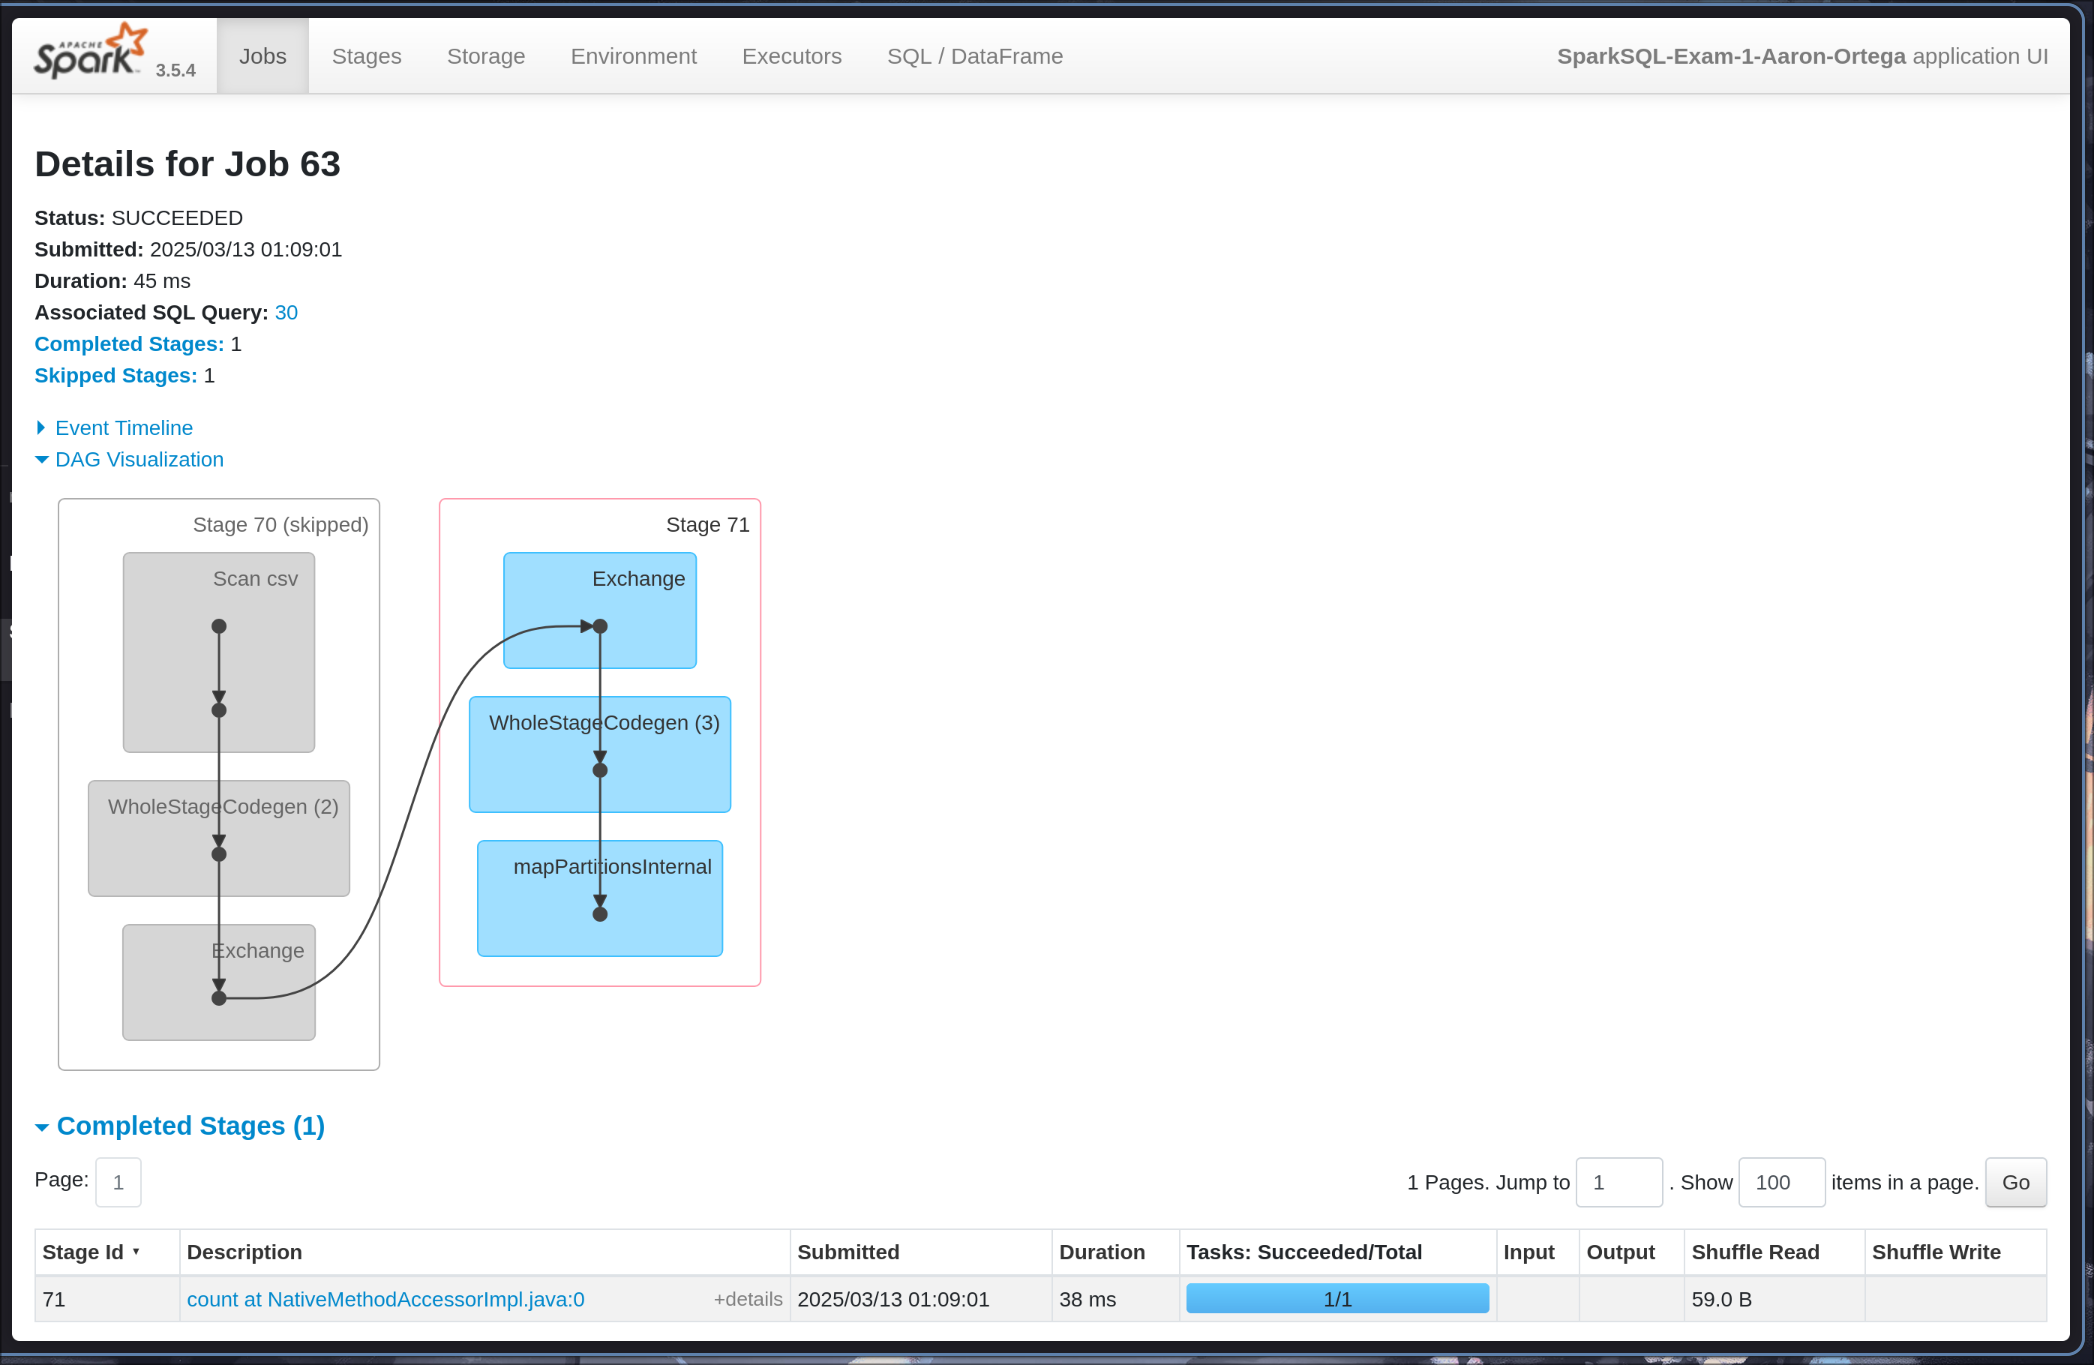

In [ ]:
# Stop the SparkContext
sc.stop()